In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import timedelta, datetime, date
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
#import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, between

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# explore measurement table with inspector
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
most_recent_entry = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())[2:-3]
most_recent_entry = dt.datetime.strptime(most_recent_entry, "%Y-%m-%d")

one_year_ago = most_recent_entry - dt.timedelta(days=365)
one_year_ago = dt.datetime.strftime(one_year_ago, "%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame, set the index to the date column and sort the dataframe by date
precip_df = pd.DataFrame(precip, columns=["date", "prcp"]).sort_values("date", ascending=True)
precip_renamed_df = precip_df.rename(columns={"prcp":"precipitation"})
precip_renamed_df.set_index("date", inplace=True)

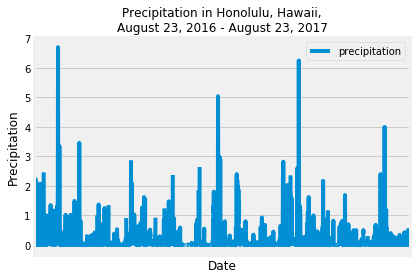

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_renamed_df.plot()
plt.title("Precipitation in Honolulu, Hawaii,\nAugust 23, 2016 - August 23, 2017", fontsize=12)
plt.xlabel("Date")
plt.xticks([])
plt.ylabel("Precipitation")
plt.legend(loc="best")
plt.savefig("Images/prcp.png")
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_renamed_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# explore station table with inspector

inspector = inspect(engine)
columns = inspector.get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_totals = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_totals

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
most_active_data = station_totals[0]
most_active_station = most_active_data[0]
most_active_station

'USC00519281'

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# convert to dataframe
temps_df = pd.DataFrame(temps, columns=["date", "tobs"])
temps_df.set_index("date", inplace=True)
temps_df

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


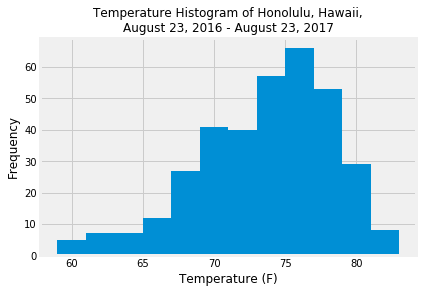

In [20]:
temps_df.hist(column="tobs", bins=12)
plt.title("Temperature Histogram of Honolulu, Hawaii,\nAugust 23, 2016 - August 23, 2017", fontsize=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.savefig("Images/hist.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# trip dates: June 10-20

vacay_temp_data = calc_temps("2017-06-10", "2017-06-21")[0] # calling index[0] pulls the tuple out of the list
vacay_temp_data

(72.0, 76.84415584415585, 83.0)

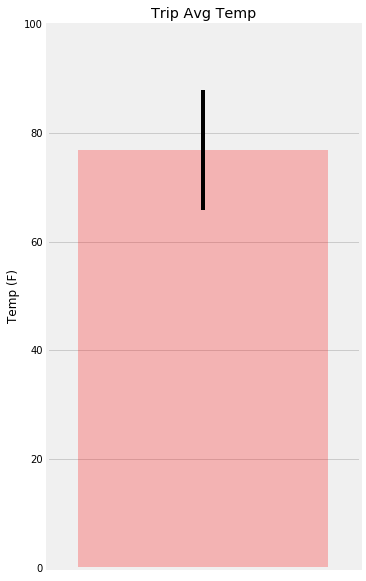

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = vacay_temp_data[2] - vacay_temp_data[0]

plt.figure(figsize=(5,10)) 
plt.bar(0, vacay_temp_data[1], yerr=yerr, color="red", alpha=.25)
plt.ylim(0,100)
plt.xlim(-.5,.5)
plt.xticks([])
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.savefig("Images/trip_avg_temp.png")
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# vacation dates: June 10-20, query dates are from most recent year, June 10-20, 2017
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, \
              func.sum(Measurement.prcp)).filter(Measurement.station==Station.station).\
              group_by(Measurement.station).order_by((func.sum(Measurement.prcp)).desc()).\
              filter(Measurement.date >= "2017-06-10").\
              filter(Measurement.date <= "2017-06-21").all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  6.569999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.2500000000000004),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2.21),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  2.1799999999999997),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.6200000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.21),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = dt.datetime.strptime("2020-06-10", "%Y-%m-%d")
end = dt.datetime.strptime("2020-06-21", "%Y-%m-%d")

# Use the start and end date to create a range of dates
date_range = (start + dt.timedelta(days=x) for x in range(0, (end-start).days))

# Strip off the year and save a list of %m-%d strings
trip_dates = [day.strftime("%m-%d") for day in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(day) for day in trip_dates]
normals

[[(68.0, 75.14285714285714, 81.0)],
 [(69.0, 76.01960784313725, 84.0)],
 [(66.0, 75.66666666666667, 83.0)],
 [(68.0, 75.66666666666667, 81.0)],
 [(69.0, 75.62711864406779, 81.0)],
 [(67.0, 75.40350877192982, 81.0)],
 [(69.0, 75.41379310344827, 81.0)],
 [(68.0, 74.59322033898304, 81.0)],
 [(69.0, 74.60344827586206, 80.0)],
 [(70.0, 75.44067796610169, 82.0)],
 [(68.0, 73.96491228070175, 85.0)]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# load dates to df
dates_df = pd.DataFrame(trip_dates, columns=["date"])

# load tuples to df
df = pd.DataFrame(normals, columns=["tobs data"])

# put tuples back into list
tobs_list = df["tobs data"].tolist()
tobs_df = pd.DataFrame(tobs_list, columns=["tmin", "tavg", "tmax"])

# create temporary dummy column to merge, then drop after merge
dates_df["dummy"] = [1,2,3,4,5,6,7,8,9,10,11]
tobs_df["dummy"] = [1,2,3,4,5,6,7,8,9,10,11]
trip_df = pd.merge(dates_df, tobs_df, on=["dummy"])
trip_df = trip_df.drop("dummy", axis=1).set_index("date")
trip_df


,tmin,tavg,tmax
date,,,
06-10,68.0,75.142857,81.0
06-11,69.0,76.019608,84.0
06-12,66.0,75.666667,83.0
06-13,68.0,75.666667,81.0
06-14,69.0,75.627119,81.0
06-15,67.0,75.403509,81.0
06-16,69.0,75.413793,81.0
06-17,68.0,74.593220,81.0
06-18,69.0,74.603448,80.0


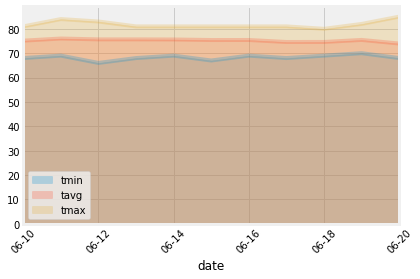

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False, alpha=.25)
plt.xticks(rotation=45)
plt.savefig("Images/trip_normals.png")
plt.show()